In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew

In [42]:
dataframe = pd.DataFrame(pd.read_csv("./wine-quality-white-and-red.csv"))
dataframe.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [43]:
columns_to_select = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','sulphates']
df = dataframe[columns_to_select]
df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates
0,7.0,0.27,0.36,0.045,45.0,170.0,0.45
1,6.3,0.30,0.34,0.049,14.0,132.0,0.49
2,8.1,0.28,0.40,0.050,30.0,97.0,0.44
3,7.2,0.23,0.32,0.058,47.0,186.0,0.40
4,7.2,0.23,0.32,0.058,47.0,186.0,0.40


In [44]:
df['free sulfur dioxide'] = df['free sulfur dioxide']/1000
df['total sulfur dioxide'] = df['total sulfur dioxide']/1000
df.head()

/tmp/ipykernel_3161/4216413678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['free sulfur dioxide'] = df['free sulfur dioxide']/1000
/tmp/ipykernel_3161/4216413678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total sulfur dioxide'] = df['total sulfur dioxide']/1000


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates
0,7.0,0.27,0.36,0.045,0.045,0.170,0.45
1,6.3,0.30,0.34,0.049,0.014,0.132,0.49
2,8.1,0.28,0.40,0.050,0.030,0.097,0.44
3,7.2,0.23,0.32,0.058,0.047,0.186,0.40
4,7.2,0.23,0.32,0.058,0.047,0.186,0.40


In [45]:
# Chuyển đổi các giá trị để tổng mỗi hàng bằng 1
df = df.div(df.sum(axis=1), axis=0)*100
df.head()



,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates
0,83.932854,3.237410,4.316547,0.539568,0.539568,2.038369,5.395683
1,82.622951,3.934426,4.459016,0.642623,0.183607,1.731148,6.426230
2,86.197723,2.979674,4.256678,0.532085,0.319251,1.032244,4.682345
3,85.297950,2.724796,3.791020,0.687122,0.556806,2.203530,4.738775
4,85.297950,2.724796,3.791020,0.687122,0.556806,2.203530,4.738775


In [46]:
# Chuyển đổi CLR
clr_transformed = clr(df + 1e-10)  # Thêm một giá trị nhỏ để tránh log(0)

# Chuyển đổi thành DataFrame
clr_df = pd.DataFrame(clr_transformed, columns=columns_to_select)

# Xác định biến đầu ra

# Loại bỏ các điểm bất thường
y = dataframe['residual sugar']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_df, y, test_size=0.3, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:         residual sugar   No. Observations:                 4547
Model:                            RLM   Df Residuals:                     4540
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 24 Jun 2024                                         
Time:                        14:33:16                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0452      0.056     89.681      0.0

In [47]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 4.361951757806472


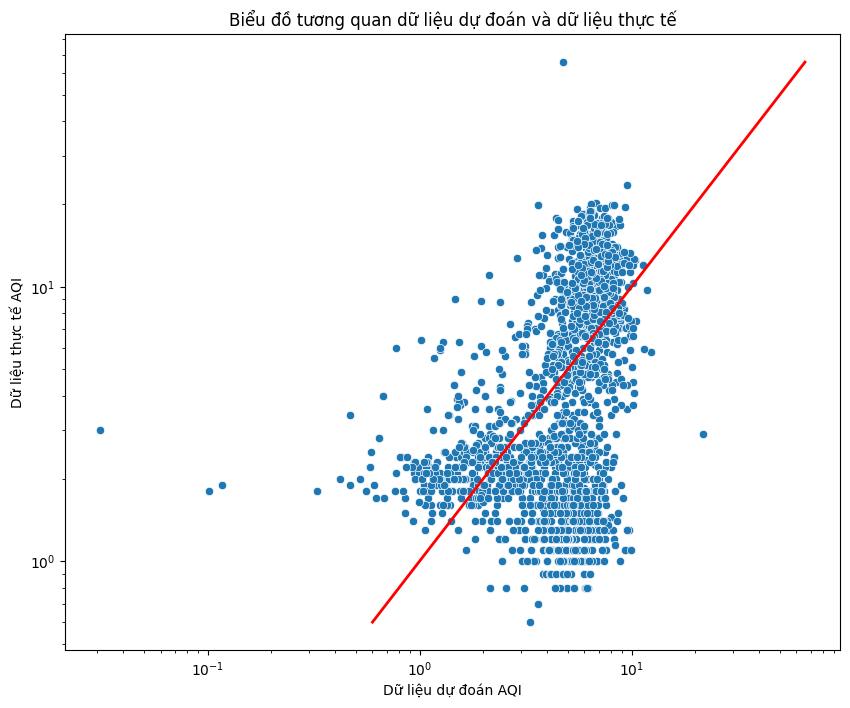

In [48]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán AQI')
plt.ylabel('Dữ liệu thực tế AQI')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()

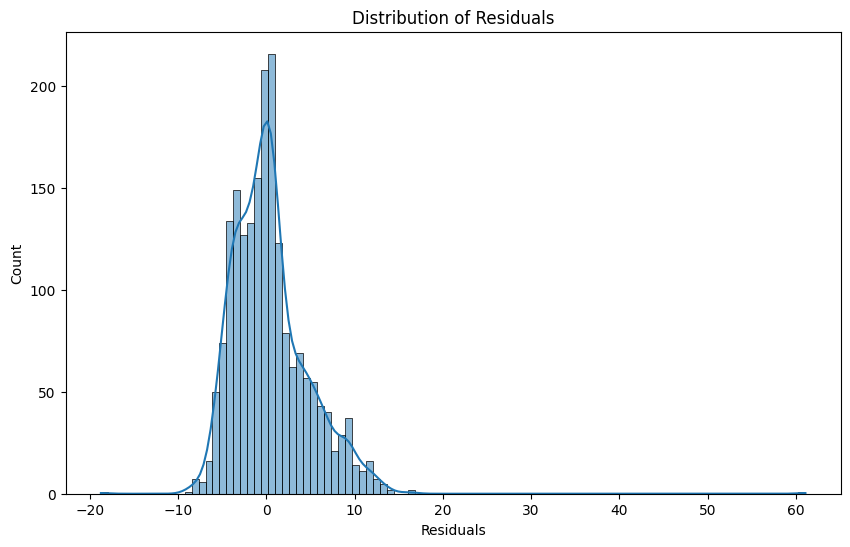

In [49]:
# Vẽ biểu đồ phân phối phần dư
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

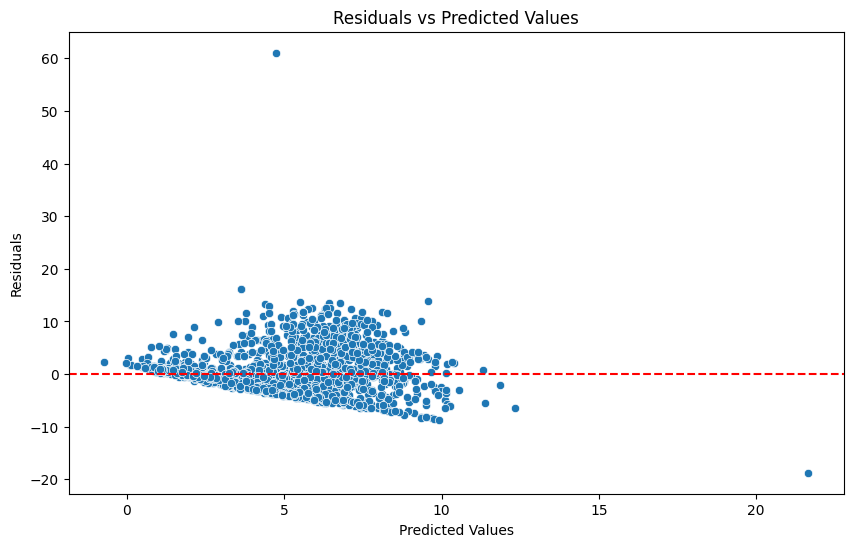

In [50]:
# Vẽ biểu đồ Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()